<a href="https://www.kaggle.com/code/davewilliamsdata/early-failure-prediction-air-production-unit?scriptVersionId=153784881" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
    log_loss,
    roc_auc_score,
    precision_score,
    recall_score,
    RocCurveDisplay,
    ConfusionMatrixDisplay
)

import numpy as np 
import pandas as pd 

import plotly
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import html
import os

# Predictive Maintenance of the Air Production Unit on a MetroPT3 locomotive 

Evaluating early failure prediction Models via a condition-based maintenance approach. Examining data from an Air Production Unit to classify when a unit is approaching failure. I will examine this data for signs of failure during the hour, day, and week leading up to a failure. I then train classification models to predict whether the various measurements of pressure and temperature are operating under a healthy state, or a state indicative of nearing failure. 

# Dataset Description

<h3>From the creators of the Dataset:</h3>

<p style="font-size:18;">The dataset was collected to support the development of predictive maintenance, anomaly detection, and remaining
useful life (RUL) prediction models for compressors using deep learning and machine learning methods.
It consists of multivariate time series data obtained from several analogue and digital sensors installed on the
compressor of a train. The data span between February and August 2020 and includes 15 signals, such as pressures,
motor current, oil temperature, and electrical signals of air intake valves. The monitoring and logging of industrial
equipment events, such as temporal behaviour and fault events, were obtained from records generated by the
sensors. The data were logged at 1Hz by an onboard embedded device. You can find a schematic diagram of the air
production unit of the compressor system in Figure 4 of the accompanying paper [1]. Also, the paper [2] provides a
detailed examination of data collection and specifications of various types of potential failures in an air compressor
system.</p>

<h3>Attribute Information:</h3>
<h4>The dataset consists of 1,516,948 data points collected at 1Hz  from February to August 2020 and is described by 15 features from 7 analogue (1-7) and 8 digital (8-15) sensors:</h4>
<ol>
    <li>TP2 (bar) – the measure of the pressure on the compressor.</li>
    <li>TP3 (bar) – the measure of the pressure generated at the pneumatic panel.</li>
    <li>H1 (bar) – the measure of the pressure generated due to pressure drop when the discharge of the cyclonic separator filter occurs.</li>
    <li>DV pressure (bar) – the measure of the pressure drop generated when the towers discharge air dryers; a zero reading indicates that the compressor is operating under load.</li>
    <li>Reservoirs (bar) – the measure of the downstream pressure of the reservoirs, which should be close to the pneumatic panel pressure (TP3).</li>
    <li>Motor Current (A) –  the measure of the current of one phase of the three-phase motor; it presents values close to 0A - when it turns off, 4A - when working offloaded, 7A - when working under load, and 9A - when it starts working.</li>
    <li>Oil Temperature (ºC) –  the measure of the oil temperature on the compressor.</li>
    <li>COMP - the electrical signal of the air intake valve on the compressor; it is active when there is no air intake, indicating that the compressor is either turned off or operating in an offloaded state.</li>
    <li>DV electric – the electrical signal that controls the compressor outlet valve; it is active when the compressor is functioning under load and inactive when the compressor is either off or operating in an offloaded state.</li>
    <li>TOWERS – the electrical signal that defines the tower responsible for drying the air and the tower responsible for draining the humidity removed from the air; when not active, it indicates that tower one is functioning; when active, it indicates that tower two is in operation.</li>
    <li>MPG – the electrical signal responsible for starting the compressor under load by activating the intake valve when the pressure in the air production unit (APU) falls below 8.2 bar; it activates the COMP sensor, which assumes the same behaviour as the MPG sensor.</li>
    <li>LPS – the electrical signal that detects and activates when the pressure drops below 7 bars.</li>
    <li>Pressure Switch - the electrical signal that detects the discharge in the air-drying towers.</li>
    <li>Oil Level – the electrical signal that detects the oil level on the compressor; it is active when the oil is below the expected values.</li>
    <li>Caudal Impulse – the electrical signal that counts the pulse outputs generated by the absolute amount of air flowing from the APU to the reservoirs.</li>
</ol>

In [2]:
# Reading in MetroPT3 Air Compressor data
metro_df_large = pd.read_csv('/kaggle/input/metropt-3-dataset/MetroPT3(AirCompressor).csv', header=0 , index_col ='timestamp')
metro_df_large.head()

,Unnamed: 0,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_eletric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses
timestamp,,,,,,,,,,,,,,,,
2020-02-01 00:00:00,0,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:10,10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:19,20,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:29,30,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
2020-02-01 00:00:39,40,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0


In [3]:
# Renaming columns for legibility, and dropping the duplicate index
metro_df_large = metro_df_large.rename(columns={'DV_eletric':'DV_electric'}).drop(columns=['Unnamed: 0'], axis=1)

In [4]:
# Examining null count and data types of features
metro_df_large.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1516948 entries, 2020-02-01 00:00:00 to 2020-09-01 03:59:50
Data columns (total 15 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   TP2              1516948 non-null  float64
 1   TP3              1516948 non-null  float64
 2   H1               1516948 non-null  float64
 3   DV_pressure      1516948 non-null  float64
 4   Reservoirs       1516948 non-null  float64
 5   Oil_temperature  1516948 non-null  float64
 6   Motor_current    1516948 non-null  float64
 7   COMP             1516948 non-null  float64
 8   DV_electric      1516948 non-null  float64
 9   Towers           1516948 non-null  float64
 10  MPG              1516948 non-null  float64
 11  LPS              1516948 non-null  float64
 12  Pressure_switch  1516948 non-null  float64
 13  Oil_level        1516948 non-null  float64
 14  Caudal_impulses  1516948 non-null  float64
dtypes: float64(15)
memory usage: 185.2+ MB


<h3>Failure Information:</h3>

<p>The dataset is unlabeled, but the failure reports provided by the company are available in the following table. This allows for the creation of a dataframe of values during normal operation, and targeting the time periods leading up to the failures. From this we can train machine learning algorithms for the purpose of anomaly detection, failure prediction, and RUL estimation algorithms. <br><br>Below is the air compressor failure information provided with the dataset. The failures were all of the same type 'air leak due to high stress'. As such, these models may be of specific use for warning of an imminent failure due to an air leak, and would not be expected to generalize well to detect other types of failure, e.g. oil leak.</p>
<table>
    <tr>
        <th>Failure Number</th>
        <th>Start Time</th>
        <th>End Time</th>
        <th>Failure Type</th>
        <th>Severity</th>
        <th>Report</th>
    </tr>
    <tr>
        <td>1</td>
        <td>4/18/2020 0:00</td>
        <td>4/18/2020 23:59</td>
        <td>Air leak</td>
        <td>High Stress</td>
        <td>N/A</td>
    </tr>
    <tr>
        <td>2</td>
        <td>5/29/2020 23:30</td>
        <td>5/30/2020 6:00</td>
        <td>Air leak</td>
        <td>High Stress</td>
        <td>Maintenance on 4/30/2020 12:00</td>
    </tr>
    <tr>
        <td>3</td>
        <td>6/5/2020 10:00</td>
        <td>6/7/2020 14:30</td>
        <td>Air leak</td>
        <td>High Stress</td>
        <td>Maintenance on 6/08/2020 16:00</td>
    </tr>
    <tr>
        <td>4</td>
        <td>7/15/2020 14:30</td>
        <td>7/15/2020 19:00</td>
        <td>Air leak</td>
        <td>High Stress</td>
        <td>Maintenance on 7/16/2020 00:00</td>
    </tr>
</table>

In [5]:
# Creating python string variable from the html table of failure data I created above
failure_table_html = """<table>
    <thead>
        <th>Failure Number</th>
        <th>Start Time</th>
        <th>End Time</th>
        <th>Failure Type</th>
        <th>Severity</th>
        <th>Report</th>
    </thead>
    <tr>
        <td>1</td>
        <td>4/18/2020 0:00</td>
        <td>4/18/2020 23:59</td>
        <td>Air leak</td>
        <td>High Stress</td>
        <td>N/A</td>
    </tr>
    <tr>
        <td>2</td>
        <td>5/29/2020 23:30</td>
        <td>5/30/2020 6:00</td>
        <td>Air leak</td>
        <td>High Stress</td>
        <td>Maintenance on 4/30/2020 12:00</td>
    </tr>
    <tr>
        <td>3</td>
        <td>6/5/2020 10:00</td>
        <td>6/7/2020 14:30</td>
        <td>Air leak</td>
        <td>High Stress</td>
        <td>Maintenance on 6/08/2020 16:00</td>
    </tr>
    <tr>
        <td>4</td>
        <td>7/15/2020 14:30</td>
        <td>7/15/2020 19:00</td>
        <td>Air leak</td>
        <td>High Stress</td>
        <td>Maintenance on 7/16/2020 00:00</td>
    </tr>
</table>"""

In [6]:
# Converting html table to to pandas dataframe
failures_from_html = pd.read_html(failure_table_html)[0]
failures_from_html

,Failure Number,Start Time,End Time,Failure Type,Severity,Report
0,1,4/18/2020 0:00,4/18/2020 23:59,Air leak,High Stress,NaN
1,2,5/29/2020 23:30,5/30/2020 6:00,Air leak,High Stress,Maintenance on 4/30/2020 12:00
2,3,6/5/2020 10:00,6/7/2020 14:30,Air leak,High Stress,Maintenance on 6/08/2020 16:00
3,4,7/15/2020 14:30,7/15/2020 19:00,Air leak,High Stress,Maintenance on 7/16/2020 00:00


#  Data Pre-Processing

In [7]:
# Examining the data type of the index as it needs to be of type datetime
metro_df_large.index.dtype

dtype('O')

In [8]:
# Converting index to datetime datatype
metro_df_large.index = pd.to_datetime(metro_df_large.index) 

# Removing rows that occur during failed periods to create a dataframe of records during normal operation
normal_op_df = pd.DataFrame(metro_df_large.loc[((metro_df_large.index < failures_from_html['Start Time'][0]) | (metro_df_large.index >failures_from_html['End Time'][0])) & 
                  ((metro_df_large.index < failures_from_html['Start Time'][1]) | (metro_df_large.index >failures_from_html['End Time'][1])) &
                  ((metro_df_large.index < failures_from_html['Start Time'][2]) | (metro_df_large.index >failures_from_html['End Time'][2])) &
                  ((metro_df_large.index < failures_from_html['Start Time'][3]) | (metro_df_large.index >failures_from_html['End Time'][3]))])

normal_op_df.shape

(1486994, 15)

In [9]:
# Creating a dataframe of failure data from the provided failure table

dt_fail_starts = pd.to_datetime(failures_from_html['Start Time'])
dt_fail_ends = pd.to_datetime(failures_from_html['End Time'])

fail_ranges_week = [pd.date_range(start=(fail_start - pd.Timedelta(days=7)), end=fail_start) for fail_start in dt_fail_starts]
fail_ranges_day = [pd.date_range(start=(fail_start - pd.Timedelta(days=1)), end=fail_start) for fail_start in dt_fail_starts]
fail_ranges_hour = [pd.date_range(start=(fail_start - pd.Timedelta(hours=1)), end=fail_start) for fail_start in dt_fail_starts]

failure_df = pd.DataFrame(list(zip(fail_ranges_week, fail_ranges_day, fail_ranges_hour, dt_fail_starts, dt_fail_ends)), columns=['pre_fail_week','pre_fail_day','pre_fail_hour','failure_start','failure_end'])


failure_df

,pre_fail_week,pre_fail_day,pre_fail_hour,failure_start,failure_end
0,"DatetimeIndex(['2020-04-11', '2020-04-12', '20...","DatetimeIndex(['2020-04-17', '2020-04-18'], dt...","DatetimeIndex(['2020-04-17 23:00:00'], dtype='...",2020-04-18 00:00:00,2020-04-18 23:59:00
1,"DatetimeIndex(['2020-05-22 23:30:00', '2020-05...","DatetimeIndex(['2020-05-28 23:30:00', '2020-05...","DatetimeIndex(['2020-05-29 22:30:00'], dtype='...",2020-05-29 23:30:00,2020-05-30 06:00:00
2,"DatetimeIndex(['2020-05-29 10:00:00', '2020-05...","DatetimeIndex(['2020-06-04 10:00:00', '2020-06...","DatetimeIndex(['2020-06-05 09:00:00'], dtype='...",2020-06-05 10:00:00,2020-06-07 14:30:00
3,"DatetimeIndex(['2020-07-08 14:30:00', '2020-07...","DatetimeIndex(['2020-07-14 14:30:00', '2020-07...","DatetimeIndex(['2020-07-15 13:30:00'], dtype='...",2020-07-15 14:30:00,2020-07-15 19:00:00


In [10]:
# Using the explode method to create records that contain an hour, day, and week pre failure related to each failure start time
for col in failure_df.columns:
    failure_df = failure_df.explode(col)

failure_df

,pre_fail_week,pre_fail_day,pre_fail_hour,failure_start,failure_end
0,2020-04-11 00:00:00,2020-04-17 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-11 00:00:00,2020-04-18 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-12 00:00:00,2020-04-17 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-12 00:00:00,2020-04-18 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
0,2020-04-13 00:00:00,2020-04-17 00:00:00,2020-04-17 23:00:00,2020-04-18 00:00:00,2020-04-18 23:59:00
...,...,...,...,...,...
3,2020-07-13 14:30:00,2020-07-15 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00
3,2020-07-14 14:30:00,2020-07-14 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00
3,2020-07-14 14:30:00,2020-07-15 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00
3,2020-07-15 14:30:00,2020-07-14 14:30:00,2020-07-15 13:30:00,2020-07-15 14:30:00,2020-07-15 19:00:00


In [11]:
# Creating an hour pre failure dataframe by setting the 'pre_fail_hour' variable as the index
# Sorting this index for proper merging
hour_pre = failure_df.set_index(failure_df['pre_fail_hour']).sort_index()

In [12]:
# Merging the hour pre failure df with the normal operation df
# This creates a column containg a datetime exactly one hour prior to the start of a failure

# Creating a one_hour variable so the merge will match all records an hour prior to failure
one_hour=pd.Timedelta(hours=1)

# Using merge_asof to recombine the hour_pre dataframe with the normal operation dataframe
# tolerance = one_hour and direction='backward' will match all normal_op_df['timestamp'] records within one hour of the failure start
hour_pre_fail_df = pd.merge_asof(normal_op_df, hour_pre, left_index=True, right_index=True, tolerance=one_hour, direction='backward')

# Creating a binary feature which will be 1 if the record occurs within the hour before a failure occured
hour_pre_fail_df['pre_fail_hour_binary'] = np.where(np.isnan(hour_pre_fail_df['pre_fail_hour'].values), 0, 1)

# Checking the value counts of the new column
# Records take place about every 10 seconds, so an hour should contain ~360 values of 1 for each of the 4 failures, should equal ~1440
hour_pre_fail_df['pre_fail_hour_binary'].value_counts()

pre_fail_hour_binary
0    1485607
1       1387
Name: count, dtype: int64

In [13]:
# Creating an hour pre failure dataframe by setting the 'pre_fail_day' variable as the index
# Sorting this index for proper merging
day_pre = failure_df.set_index(failure_df['pre_fail_day']).sort_index()

In [14]:
# Merging the day pre failure df with the normal operation df
# This creates a column containing a datetime exactly one day prior to the start of a failure

# Creating a one_day variable so the merge will match all records a day prior to failure
one_day=pd.Timedelta(1, "D")

# Using merge_asof to recombine the day_pre dataframe with the normal operation dataframe
# tolerance = one_day and direction='backward' will match all normal_op_df['timestamp'] records within one day of the failure start
day_pre_fail_df = pd.merge_asof(normal_op_df, day_pre, left_index=True, right_index=True, tolerance=one_day)

# Creating a binary feature which will be 1 if the record occurs within the day before a failure occured
day_pre_fail_df['pre_fail_day_binary'] = np.where(np.isnan(day_pre_fail_df['pre_fail_day'].values), 0, 1)

# Checking the value counts of the new column
# Records take place about every 10 seconds, so a day should contain ~6*60*24 values of 1 for each of the 4 failures, should be close to ~8640*4 = 34560
day_pre_fail_df['pre_fail_day_binary'].value_counts()

pre_fail_day_binary
0    1445026
1      41968
Name: count, dtype: int64

In [15]:
# Creating an hour pre failure dataframe by setting the 'pre_fail_week' variable as the index
# Sorting this index for proper merging
week_pre = failure_df.set_index(failure_df['pre_fail_week']).sort_index()

In [16]:
# Creating a one_week variable so the merge will match all records a day prior to failure
one_week=pd.Timedelta(1, "W")

# Using merge_asof to recombine the week_pre dataframe with the normal operation dataframe
# tolerance = one_week and direction='backward' will match all normal_op_df['timestamp'] records within one week of the failure start
week_pre_fail_df = pd.merge_asof(normal_op_df, week_pre, left_index=True, right_index=True, tolerance=one_week)

# Creating a binary feature which will be 1 if the record occurs within the week before a failure occured
week_pre_fail_df['pre_fail_week_binary'] = np.where(np.isnan(week_pre_fail_df['pre_fail_week'].values), 0, 1)

# Checking the value counts of the new column
# Records take place about every 10 seconds, so a week should contain ~6*60*24*7 values of 1 for each of the 4 failures, should be close to ~60480 * 4 = 241920
week_pre_fail_df['pre_fail_week_binary'].value_counts()

pre_fail_week_binary
0    1169154
1     317840
Name: count, dtype: int64

In [17]:
# Creating a dataframe of only the binary pre_failure columns
pre_failures_df = pd.DataFrame({'pre_fail_week':week_pre_fail_df['pre_fail_week_binary'],'pre_fail_day':day_pre_fail_df['pre_fail_day_binary'],'pre_fail_hour':hour_pre_fail_df['pre_fail_hour_binary']})

# Sanity check on value counts of df
print(pre_failures_df.value_counts())
pre_failures_df.head()

pre_fail_week  pre_fail_day  pre_fail_hour
0              0             0                1169154
1              0             0                 275872
               1             0                  40581
                             1                   1387
Name: count, dtype: int64


,pre_fail_week,pre_fail_day,pre_fail_hour
timestamp,,,
2020-02-01 00:00:00,0,0,0
2020-02-01 00:00:10,0,0,0
2020-02-01 00:00:19,0,0,0
2020-02-01 00:00:29,0,0,0
2020-02-01 00:00:39,0,0,0


In [18]:
# Checking that the failure df is of the same length as the normal operation df
print(pre_failures_df.shape[0], normal_op_df.shape[0])

1486994 1486994


In [19]:
# Merging the dataframe of binary pre failure columns with the normal operation dataframe
model_df = normal_op_df.merge(pre_failures_df, left_index=True, right_index=True)

model_df.head()

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,pre_fail_week,pre_fail_day,pre_fail_hour
timestamp,,,,,,,,,,,,,,,,,,
2020-02-01 00:00:00,-0.012,9.358,9.340,-0.024,9.358,53.600,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0
2020-02-01 00:00:10,-0.014,9.348,9.332,-0.022,9.348,53.675,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0
2020-02-01 00:00:19,-0.012,9.338,9.322,-0.022,9.338,53.600,0.0425,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0
2020-02-01 00:00:29,-0.012,9.328,9.312,-0.022,9.328,53.425,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0
2020-02-01 00:00:39,-0.012,9.318,9.302,-0.022,9.318,53.475,0.0400,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0


In [20]:
hour_pre_fail_df = model_df[model_df['pre_fail_hour'] == 1]
day_pre_fail_df = model_df[model_df['pre_fail_day'] == 1]
week_pre_fail_df = model_df[model_df['pre_fail_week'] == 1]

failure_1_df = model_df[:failures_from_html['Start Time'][0]]
failure_2_df = model_df[failures_from_html['End Time'][0]:failures_from_html['Start Time'][1]]
failure_3_df = model_df[failures_from_html['End Time'][1]:failures_from_html['Start Time'][2]]
failure_4_df = model_df[failures_from_html['End Time'][2]:failures_from_html['Start Time'][3]]

In [21]:

# Creating binary features in the main model df where 1 indicates a record in period between prior failure end and start of failure n
model_df['failure_1'] = model_df.index < failures_from_html['Start Time'][0]
model_df['failure_2'] = (model_df.index > failures_from_html['End Time'][0]) & (model_df.index < failures_from_html['Start Time'][1])
model_df['failure_3'] = (model_df.index > failures_from_html['End Time'][1]) & (model_df.index < failures_from_html['Start Time'][2])
model_df['failure_4'] = (model_df.index > failures_from_html['End Time'][2]) & (model_df.index < failures_from_html['Start Time'][3])

In [22]:
# Checking the value counts of the binary columns
# They all have a decent enough balance between 1-0 classes to be used, 
# except the pre_fail_hour which I am including for experimentation on heavily imbalanced classes and examination of acute near failure values
model_df[['COMP','DV_electric','Towers','MPG','LPS','Pressure_switch','Oil_level','Caudal_impulses','pre_fail_week','pre_fail_day','pre_fail_hour']].apply(pd.Series.value_counts)

,COMP,DV_electric,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,pre_fail_week,pre_fail_day,pre_fail_hour
0.0,217507,1273157,106668,224019,1482534,12831,145371,95386,1169154,1445026,1485607
1.0,1269487,213837,1380326,1262975,4460,1474163,1341623,1391608,317840,41968,1387


# Exploratory Data Analysis

<h3>Examining the various measurements and the differences between the values during normal operation and the different periods close to failure.</h3>

In [23]:
# This calculates the correlation between each feature and all of the others
corr = model_df.corr()
for col in ['pre_fail_week','pre_fail_day','pre_fail_hour']:
    print('\n Correlations between ' f'{col}' + ' and features: \n',corr[col].sort_values(ascending=False))


 Correlations between pre_fail_week and features: 
 pre_fail_week      1.000000
failure_3          0.349191
pre_fail_day       0.326853
failure_2          0.141686
Oil_temperature    0.123102
Oil_level          0.097581
failure_4          0.083065
pre_fail_hour      0.058603
Caudal_impulses    0.053297
LPS                0.028609
DV_electric        0.019743
Motor_current      0.012676
DV_pressure        0.008222
H1                 0.004146
TP2               -0.006293
TP3               -0.008548
Reservoirs        -0.008583
COMP              -0.014352
Towers            -0.032104
MPG               -0.037071
Pressure_switch   -0.067335
failure_1         -0.247946
Name: pre_fail_week, dtype: float64

 Correlations between pre_fail_day and features: 
 pre_fail_day       1.000000
pre_fail_week      0.326853
failure_3          0.313968
pre_fail_hour      0.179294
Oil_temperature    0.057313
Oil_level          0.030557
Caudal_impulses    0.029867
Motor_current      0.012231
TP2                

<div >
    <h4>Initial Indicators of Failure States</h4>
        <p>Top Correlations of Features and Failure Periods<p>
            <p>During the week leading up to failure:</p>
            <ol>
                <li>Oil Temperature</li>
                <li>Low Oil Level Signal</li>
                <li>Pressure Switch (negative correlation)</li>
                <li>Caudal Impulses</li>
            </ol>
            <p>During the day leading up to failure:</p>
            <ol>
                <li>Oil Temperature</li>
                <li>Low Oil Level Signal</li>
                <li>Caudal Impulses</li>
            </ol>  
            <p>During the hour leading up to failure:</p>
            <ol>
                <li>DV pressure</li>
                <li>COMP (negative correlation)</li>
                <li>MPG (negative correlation)</li>
            </ol>
</div>
    <p>These findings indicate that the APU system operating for a sustained period (week, day) with a high oil temperature, low oil, and high volume of air moving through the system, can lead to increased stress on the system. This is shown by the higher correlations during the final hour before a failure changing to values that indicate the APU operating under load, with an increase towards zero of the DV pressure value, increased pressure in the compressor (TP2), and an increase in DV electric, all of which indicate that the system is operating under load.</p><br>
    <p>I will focus on these features to verify these findings and to support feature generation to improve the ML model performance.</p>

Oil Temperature (ºC) – the measure of the oil temperature on the compressor.

On average, the oil temperature is ~2 degrees Celsius higher during the week leading up to a failure.

In [24]:
oiltemp_mean_comparison = model_df.groupby('pre_fail_week')['Oil_temperature'].mean()
oiltemp_mean_comparison

pre_fail_week
0    61.978839
1    63.870764
Name: Oil_temperature, dtype: float64

Oil Level – the electrical signal that detects the oil level on the compressor; it is active when the oil is below the expected values.

During the week pre failure the rate of Low Oil Signals is ~3 times higher than during normal operation.



In [25]:
oil_level_counts = model_df.groupby('pre_fail_week')['Oil_level'].value_counts()
normal_op_oil_level_ratio = oil_level_counts[0][1] / oil_level_counts[0][0]
pre_fail_week_oil_level_ratio = oil_level_counts[1][1] / oil_level_counts[1][0]

print('Low Oil Level ratio during Normal Operation:'+f'{normal_op_oil_level_ratio}'+'\n\n'+'Low Oil Level ratio during Week Pre Failure: '+f'{pre_fail_week_oil_level_ratio}')
print('\n',oil_level_counts)

Low Oil Level ratio during Normal Operation:7.859576402834085

Low Oil Level ratio during Week Pre Failure: 22.70878711024914

 pre_fail_week  Oil_level
0              1.0          1037189
               0.0           131965
1              1.0           304434
               0.0            13406
Name: count, dtype: int64


Pressure Switch - the electrical signal that detects the discharge in the air-drying towers.

The rate of pressure switch activations during the week pre failure is ~4x higher than during normal operation. Another indicator of the system operating under load.

In [26]:
pswitch_counts = model_df.groupby('pre_fail_week')['Pressure_switch'].value_counts()
normal_op_pswitch_ratio = pswitch_counts[0][0] / pswitch_counts[0][1]
pre_fail_week_pswitch_ratio = pswitch_counts[1][0] / pswitch_counts[1][1]

print('Pressure Switch ratio during Normal Operation:'+f'{normal_op_pswitch_ratio}'+'\n\n'+'Pressure Switch ratio during Week Pre Failure: '+f'{pre_fail_week_pswitch_ratio}')
print('\n',pswitch_counts)

Pressure Switch ratio during Normal Operation:0.005410788210466934

Pressure Switch ratio during Week Pre Failure: 0.021005393493756845

 pre_fail_week  Pressure_switch
0              1.0                1162862
               0.0                   6292
1              1.0                 311301
               0.0                   6539
Name: count, dtype: int64


Caudal Impulse – the electrical signal that counts the pulse outputs generated by the absolute amount of air flowing from the APU to the reservoirs.

The sum of the caudal impulse values over a time period serve as a surrogate for the volume of air flowing through the APU to the reservoirs. When this summed value is higher, the APU is operating under higher load. 

During the week pre failure the rate of caudal impulses is almost double (1.87x) that of during normal operation. This indicates a higher rate of the system operating under load.



In [27]:
caudal_counts = model_df.groupby('pre_fail_week')['Caudal_impulses'].value_counts()
normal_op_caudal_ratio = caudal_counts[0][1] / caudal_counts[0][0]
pre_fail_week_caudal_ratio = caudal_counts[1][1] / caudal_counts[1][0]

print('Caudal Impulse ratio during Normal Operation:'+f'{normal_op_caudal_ratio}'+'\n\n'+'Caudal Impulse ratio during Week Pre Failure: '+f'{pre_fail_week_caudal_ratio}')
print('\n',caudal_counts)

Caudal Impulse ratio during Normal Operation:13.093324332794909

Caudal Impulse ratio during Week Pre Failure: 24.574509172835533

 pre_fail_week  Caudal_impulses
0              1.0                1086196
               0.0                  82958
1              1.0                 305412
               0.0                  12428
Name: count, dtype: int64


I have focused on identifying the features correlated with the week pre failure, as that is feasible to put into operation. Since there are more records than an hour or day pre failure, and leaves enough time for an early warning indicator to activate, remote verification of the early warning state, and physical inspection/maintenance of the onboard APU system. 

The highest correlations with the hour pre failure status are different than those correlated with a week/day pre failure. I will examine these relationships to identify if there is a possibility of developing an acute failure warning given live updates of these measurements.

There are only 1387 records during the hour leading up to the 4 failures, and as such the findings are experimental but may be useful for predicting acute failure in the very near future. 

DV pressure (bar) – the measure of the pressure drop generated when the towers discharge air dryers; a zero reading indicates that the compressor is operating under load.

The average DV pressure value is significantly higher during the hour leading up to failure. As stated, a zero reading indicates the compressor operating under load, so this is not indicative of the system operating under higher load, but does indicate a more extreme change of pressure within the system.

In [28]:
dv_pressure_avg = model_df.groupby('pre_fail_hour')['DV_pressure'].mean()
dv_pressure_avg

pre_fail_hour
0    0.019435
1    0.217172
Name: DV_pressure, dtype: float64

COMP - the electrical signal of the air intake valve on the compressor; it is active when there is no air intake, indicating that the compressor is either turned off or operating in an offloaded state.

The signal of the air intake valve on the compressor is active 64% of the time during the hour pre failure, compared to 17% of the time during normal operation.

In [29]:
comp_counts = model_df.groupby('pre_fail_hour')['COMP'].value_counts()
normal_op_comp_ratio = comp_counts[0][0] / comp_counts[0][1]
pre_fail_hour_comp_ratio = comp_counts[1][0] / comp_counts[1][1]

print('COMP ratio during Normal Operation:'+f'{normal_op_comp_ratio}'+'\n\n'+'COMP ratio during Hour Pre Failure: '+f'{pre_fail_hour_comp_ratio}')
print('\n',comp_counts)

COMP ratio during Normal Operation:0.17102422359709893

COMP ratio during Hour Pre Failure: 0.6356132075471698

 pre_fail_hour  COMP
0              1.0     1268639
               0.0      216968
1              1.0         848
               0.0         539
Name: count, dtype: int64


MPG – the electrical signal responsible for starting the compressor under load by activating the intake valve when the pressure in the air production unit (APU) falls below 8.2 bar; it activates the COMP sensor, which assumes the same behaviour as the MPG sensor.

As stated, the MPG signal assumes the same behavior as the COMP signal previously investigated. Shown below, these ratios are almost identical to the COMP ratios and one of these features will be removed before training any model.

In [30]:
mpg_counts = model_df.groupby('pre_fail_hour')['MPG'].value_counts()
normal_op_mpg_ratio = mpg_counts[0][0] / mpg_counts[0][1]
pre_fail_hour_mpg_ratio = mpg_counts[1][0] / mpg_counts[1][1]

print('COMP ratio during Normal Operation:'+f'{normal_op_mpg_ratio}'+'\n\n'+'COMP ratio during Hour Pre Failure: '+f'{pre_fail_hour_mpg_ratio}')
print('\n',mpg_counts)

COMP ratio during Normal Operation:0.17706617479857414

COMP ratio during Hour Pre Failure: 0.6356132075471698

 pre_fail_hour  MPG
0              1.0    1262127
               0.0     223480
1              1.0        848
               0.0        539
Name: count, dtype: int64


Now I will examine some relationships between features that would indicate an abnormality in operation, given my limited expertise with this machinery. For example, the difference in pressure between the pneumatic panel and the down stream reservoirs should be close to zero, any value indicates a pressure loss in the system.

The pressure measured at the Reservoirs should be close to that measure at the pneumatic panel. Here, I examine the difference between these values, comparing the average size of the difference between the periods a week, day, and hour pre failure to the values during normal operation. The difference is quite small between the week leading to failure and normal operation, increases and is positive the day pre failure, and the difference increases further during the hour pre failure. The latter value is also negative, indicating a pressure loss between the pneumatic panel and the downstream reservoirs.

In [31]:
# Creating a column of the difference in air pressure between the pneumatic panel and the reservoirs
model_df['air_pressure_diff'] = model_df['TP3'] - model_df['Reservoirs']

air_press_diff_week = model_df.groupby('pre_fail_week')['air_pressure_diff'].mean()
print("Reservoir minus Pneumatic Panel Pressure Average: Pre Fail Week vs Normal: "+f'{air_press_diff_week[0]-air_press_diff_week[1]:.20f}'+'\n')

air_press_diff_day = model_df.groupby('pre_fail_day')['air_pressure_diff'].mean()
print("Reservoir minus Pneumatic Panel Pressure Average: Pre Fail Day vs Normal: "+f'{air_press_diff_day[0]-air_press_diff_day[1]}'+'\n')

air_press_diff_hour = model_df.groupby('pre_fail_hour')['air_pressure_diff'].mean()
print("Reservoir minus Pneumatic Panel Pressure Average: Pre Fail Hour vs Normal: "+f'{air_press_diff_hour[0]-air_press_diff_hour[1]}')

Reservoir minus Pneumatic Panel Pressure Average: Pre Fail Week vs Normal: -0.00003738404320526728

Reservoir minus Pneumatic Panel Pressure Average: Pre Fail Day vs Normal: 0.00010760544175336965

Reservoir minus Pneumatic Panel Pressure Average: Pre Fail Hour vs Normal: -0.0007502015980631967


# Initial Model Training + Evaluation

Now I have a dataframe of records under normal operation, merged with the column indicating True/False if the data occured during the week/day/hour leading up to a known failure.

In [32]:
plt.figure(figsize=(12,8))

# This calculates the correlation between each feature and all of the others
corr = model_df.corr()

# Creating and plotting the heatmap with seaborn
corr

,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Motor_current,COMP,DV_electric,Towers,...,Oil_level,Caudal_impulses,pre_fail_week,pre_fail_day,pre_fail_hour,failure_1,failure_2,failure_3,failure_4,air_pressure_diff
TP2,1.000000,0.034747,-0.958212,0.313850,0.033420,0.182385,0.679523,-0.951888,0.942886,-0.614914,...,-0.000625,-0.022275,-0.006293,0.006841,0.017789,-0.043697,-0.002401,-0.007242,0.082467,0.352995
TP3,0.034747,1.000000,0.188270,-0.070826,0.999993,0.473065,0.465572,0.057638,-0.030494,0.033550,...,-0.026237,-0.048467,-0.008548,-0.013006,-0.006359,0.004521,-0.034492,0.002877,-0.007573,0.323409
H1,-0.958212,0.188270,1.000000,-0.308265,0.189531,-0.078052,-0.574239,0.968176,-0.953863,0.626966,...,-0.006203,0.010462,0.004146,-0.008362,-0.018798,0.043728,-0.005073,0.005689,-0.082452,-0.264551
DV_pressure,0.313850,-0.070826,-0.308265,1.000000,-0.070890,0.226860,0.223975,-0.306924,0.309996,-0.207369,...,0.038459,0.024766,0.008222,-0.014868,0.021771,-0.005796,0.126006,-0.004947,-0.048083,-0.006409
Reservoirs,0.033420,0.999993,0.189531,-0.070890,1.000000,0.473107,0.464466,0.058944,-0.031799,0.034408,...,-0.026240,-0.047572,-0.008583,-0.012994,-0.006403,0.004491,-0.034429,0.002749,-0.007624,0.319933
Oil_temperature,0.182385,0.473065,-0.078052,0.226860,0.473107,1.000000,0.500221,-0.157630,0.165640,-0.102722,...,-0.165620,-0.082173,0.123102,0.057313,0.014248,-0.381474,-0.112176,0.058051,0.262665,0.141323
Motor_current,0.679523,0.465572,-0.574239,0.223975,0.464466,0.500221,1.000000,-0.662049,0.671209,-0.427247,...,-0.043832,-0.060557,0.012676,0.012231,0.009013,-0.103725,-0.015609,-0.006513,0.109832,0.434603
COMP,-0.951888,0.057638,0.968176,-0.306924,0.058944,-0.157630,-0.662049,1.000000,-0.954650,0.671589,...,0.034513,0.065893,-0.014352,-0.012263,-0.020954,0.054112,-0.016913,0.008053,-0.083236,-0.318005
DV_electric,0.942886,-0.030494,-0.953863,0.309996,-0.031799,0.165640,0.671209,-0.954650,1.000000,-0.602505,...,-0.013164,-0.039220,0.019743,0.003261,0.017174,-0.052376,0.026079,-0.006818,0.064000,0.326619
Towers,-0.614914,0.033550,0.626966,-0.207369,0.034408,-0.102722,-0.427247,0.671589,-0.602505,1.000000,...,0.070191,0.101107,-0.032104,-0.016216,-0.017203,0.029878,-0.027124,0.004650,-0.025022,-0.210225


<Figure size 1200x800 with 0 Axes>

In [33]:
# Dropping the highly correlated columns
model_df = model_df.drop(columns=['H1', 'DV_electric', 'COMP'])

<Axes: >

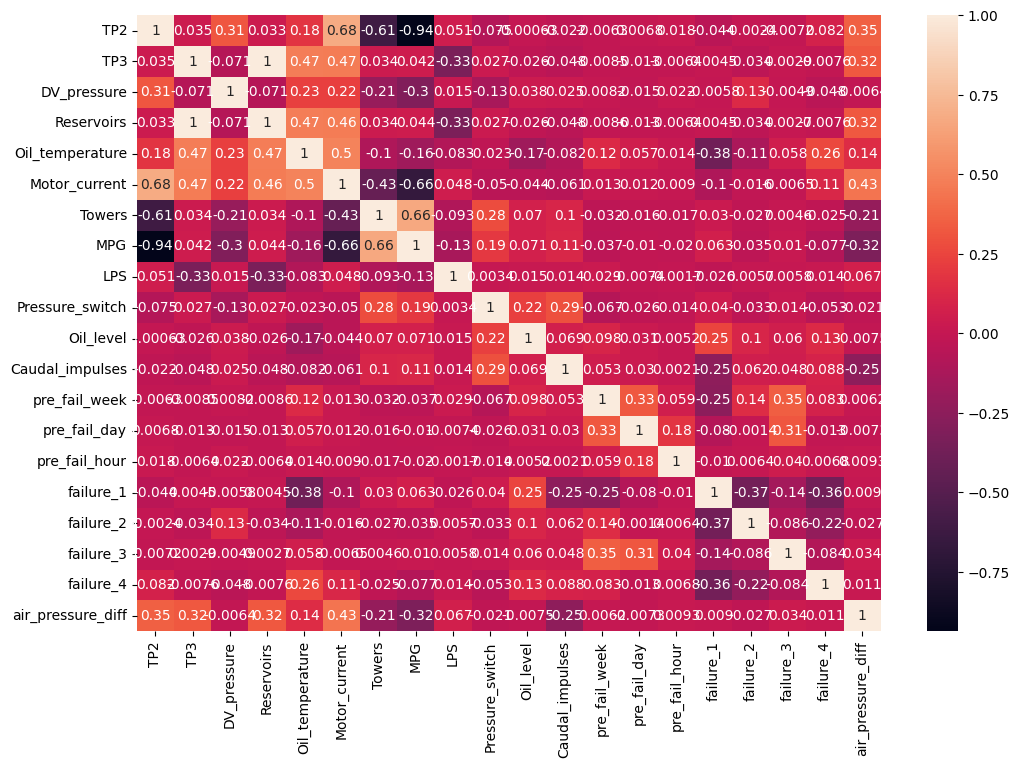

In [34]:
plt.figure(figsize=(12,8))
# This calculates the correlation between each feature and all of the others
corr = model_df.corr()
# Creating and plotting the heatmap with seaborn
sns.heatmap(corr, annot=True)

In [35]:
model_df.head()

,TP2,TP3,DV_pressure,Reservoirs,Oil_temperature,Motor_current,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,pre_fail_week,pre_fail_day,pre_fail_hour,failure_1,failure_2,failure_3,failure_4,air_pressure_diff
timestamp,,,,,,,,,,,,,,,,,,,,
2020-02-01 00:00:00,-0.012,9.358,-0.024,9.358,53.600,0.0400,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0,True,False,False,False,0.0
2020-02-01 00:00:10,-0.014,9.348,-0.022,9.348,53.675,0.0400,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0,True,False,False,False,0.0
2020-02-01 00:00:19,-0.012,9.338,-0.022,9.338,53.600,0.0425,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0,True,False,False,False,0.0
2020-02-01 00:00:29,-0.012,9.328,-0.022,9.328,53.425,0.0400,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0,True,False,False,False,0.0
2020-02-01 00:00:39,-0.012,9.318,-0.022,9.318,53.475,0.0400,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0,True,False,False,False,0.0


In [36]:
# Resetting the index to sequential integers and dropping the datetime column entirely, saving a df with datetime index for later feature generation.
model_with_dt = model_df
model_df = model_df.reset_index(drop=True)
model_df.head()

,TP2,TP3,DV_pressure,Reservoirs,Oil_temperature,Motor_current,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,pre_fail_week,pre_fail_day,pre_fail_hour,failure_1,failure_2,failure_3,failure_4,air_pressure_diff
0,-0.012,9.358,-0.024,9.358,53.600,0.0400,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0,True,False,False,False,0.0
1,-0.014,9.348,-0.022,9.348,53.675,0.0400,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0,True,False,False,False,0.0
2,-0.012,9.338,-0.022,9.338,53.600,0.0425,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0,True,False,False,False,0.0
3,-0.012,9.328,-0.022,9.328,53.425,0.0400,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0,True,False,False,False,0.0
4,-0.012,9.318,-0.022,9.318,53.475,0.0400,1.0,1.0,0.0,1.0,1.0,1.0,0,0,0,True,False,False,False,0.0


In [37]:
# Creating the X data from the pertinent columns of the model ready dataframe
X = model_df[['TP3','Reservoirs','Oil_temperature','Motor_current','MPG','LPS','Pressure_switch','Oil_level','Caudal_impulses']]

# Declaring the target column of pre_fail_week as the y or target data
y = model_df['pre_fail_week']

# Splitting the data into training and testing, stratifying by the y variable of pre_fail_hour as it has greatly imbalanced class distribution
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Using scikit learn's StandardScaler, fitting it on only the X_train data, then transforming both X_train and X_test data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train

array([[ 0.38419381,  0.38687784,  1.8361419 , ...,  0.09316536,
         0.32942596,  0.26164063],
       [-0.30444706, -0.30578585, -0.71113927, ...,  0.09316536,
         0.32942596,  0.26164063],
       [-0.26654022, -0.26466882,  0.28476037, ...,  0.09316536,
         0.32942596,  0.26164063],
       ...,
       [-0.89832083, -0.90040125, -0.23104423, ...,  0.09316536,
         0.32942596,  0.26164063],
       [ 0.52950335,  0.52920599, -0.50481744, ...,  0.09316536,
         0.32942596,  0.26164063],
       [-0.62981407, -0.62839633, -1.4888139 , ...,  0.09316536,
         0.32942596,  0.26164063]])

In [38]:
# Checking the counts of True/False values in the training and test target datasets
print(y_train.value_counts())
print(y_test.value_counts())

pre_fail_week
0    818407
1    222488
Name: count, dtype: int64
pre_fail_week
0    350747
1     95352
Name: count, dtype: int64


Accuracy: 0.7863770149675297
Precision: 0.5076156189421213
Recall: 0.019223508683614398
F1 Score: 0.6997134832705669


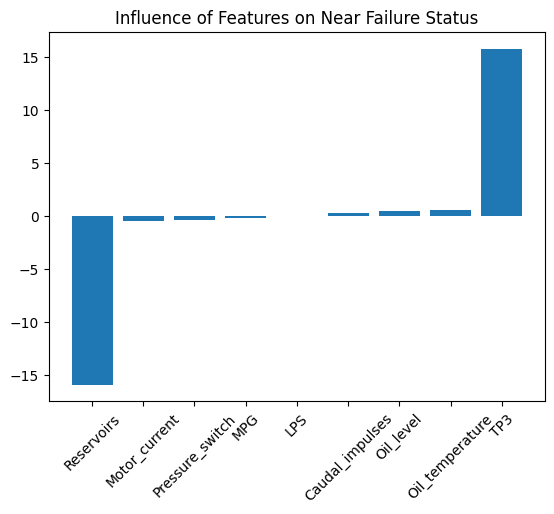

In [39]:
# Instantiating a scikit-learn Logistic Regression model with class weights set to counteract the imbalanced target classes
logreg_1 = LogisticRegression(random_state=17)

# Fitting the model with the training data
logreg_1.fit(X_train, y_train)

# Predicting target values from the test data
y_pred = logreg_1.predict(X_test)

# Accessing the feature_importances of the model after fitting
feature_importances = pd.DataFrame(data={"Feature": X.columns, "Importance": logreg_1.coef_[0]}).sort_values(by='Importance')

# Calculating and printing model evaluation metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

# Plotting the feature importances as a bar chart
plt.bar(feature_importances["Feature"], feature_importances["Importance"])
plt.xticks(rotation=45)
plt.title("Influence of Features on Near Failure Status")
plt.show()

In [40]:
# Instantiating an XGBoost Classifier model for binary classification via logistic regression (this model needs work)
xgb_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=17)

# Fitting the model to the training data
xgb_model.fit(X_train, y_train)

# Making predictions of near failure True/False on the test data
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)
# Using scikit-learn's classification report to calculate and display model evaluation metrics
print(classification_report(y_test, y_pred))

# Calculate log loss
print(log_loss(y_test, y_pred_proba))

# Calculate ROC AUC
print(roc_auc_score(y_test, y_pred_proba[:,1]))

              precision    recall  f1-score   support

           0       0.82      0.99      0.89    350747
           1       0.83      0.18      0.30     95352

    accuracy                           0.82    446099
   macro avg       0.82      0.59      0.60    446099
weighted avg       0.82      0.82      0.77    446099

0.4096964543492444
0.783472129344668


# Feature Generation

In [41]:
model_with_dt['Oil_level_rolling_sum_hour'] = model_with_dt['Oil_level'].rolling(window=pd.Timedelta(hours=1)).sum().fillna(0)
model_with_dt['Oil_level_rolling_sum_day'] = model_with_dt['Oil_level'].rolling(window=pd.Timedelta(days=1)).sum().fillna(0)
model_with_dt['Oil_level_rolling_sum_week'] = model_with_dt['Oil_level'].rolling(window=pd.Timedelta(weeks=1)).sum().fillna(0)

model_with_dt['Oil_temp_rolling_avg'] = model_with_dt['Oil_temperature'].rolling(window=pd.Timedelta(hours=1)).mean().fillna(0)
model_with_dt['Oil_temp_rolling_avg_day'] = model_with_dt['Oil_temperature'].rolling(window=pd.Timedelta(days=1)).mean().fillna(0)
model_with_dt['Oil_temp_rolling_avg_week'] = model_with_dt['Oil_temperature'].rolling(window=pd.Timedelta(weeks=1)).mean().fillna(0)

model_with_dt['motor_current_rolling_avg'] = model_with_dt['Motor_current'].rolling(window=pd.Timedelta(days=3)).mean().fillna(0)

model_with_dt['panel_reservoir_diff'] = model_with_dt['TP3'] - model_with_dt['Reservoirs']
model_with_dt['pnl_res_dif_rlng_avg_day']=  model_with_dt['panel_reservoir_diff'].rolling(window=pd.Timedelta(days=1)).mean().fillna(0)
model_with_dt['pnl_res_dif_rlng_avg_week']=  model_with_dt['panel_reservoir_diff'].rolling(window=pd.Timedelta(weeks=1)).mean().fillna(0)

model_with_dt.Oil_level_rolling_sum_hour['2020-04-17 20:00:00':'2020-04-18 00:00:00']

timestamp
2020-04-17 20:00:10    242.0
2020-04-17 20:00:22    242.0
2020-04-17 20:00:34    243.0
2020-04-17 20:00:46    242.0
2020-04-17 20:00:59    242.0
                       ...  
2020-04-17 23:59:00    234.0
2020-04-17 23:59:12    234.0
2020-04-17 23:59:24    233.0
2020-04-17 23:59:36    233.0
2020-04-17 23:59:49    233.0
Name: Oil_level_rolling_sum_hour, Length: 1193, dtype: float64

In [42]:
model_with_dt.head()

,TP2,TP3,DV_pressure,Reservoirs,Oil_temperature,Motor_current,Towers,MPG,LPS,Pressure_switch,...,Oil_level_rolling_sum_hour,Oil_level_rolling_sum_day,Oil_level_rolling_sum_week,Oil_temp_rolling_avg,Oil_temp_rolling_avg_day,Oil_temp_rolling_avg_week,motor_current_rolling_avg,panel_reservoir_diff,pnl_res_dif_rlng_avg_day,pnl_res_dif_rlng_avg_week
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-01 00:00:00,-0.012,9.358,-0.024,9.358,53.600,0.0400,1.0,1.0,0.0,1.0,...,1.0,1.0,1.0,53.6000,53.6000,53.6000,0.040000,0.0,0.0,0.0
2020-02-01 00:00:10,-0.014,9.348,-0.022,9.348,53.675,0.0400,1.0,1.0,0.0,1.0,...,2.0,2.0,2.0,53.6375,53.6375,53.6375,0.040000,0.0,0.0,0.0
2020-02-01 00:00:19,-0.012,9.338,-0.022,9.338,53.600,0.0425,1.0,1.0,0.0,1.0,...,3.0,3.0,3.0,53.6250,53.6250,53.6250,0.040833,0.0,0.0,0.0
2020-02-01 00:00:29,-0.012,9.328,-0.022,9.328,53.425,0.0400,1.0,1.0,0.0,1.0,...,4.0,4.0,4.0,53.5750,53.5750,53.5750,0.040625,0.0,0.0,0.0
2020-02-01 00:00:39,-0.012,9.318,-0.022,9.318,53.475,0.0400,1.0,1.0,0.0,1.0,...,5.0,5.0,5.0,53.5550,53.5550,53.5550,0.040500,0.0,0.0,0.0


# Model Improvements

In [43]:
# Creating the X data from the pertinent columns of the model ready dataframe
X2 = model_with_dt[['TP3','Reservoirs','LPS','Oil_level', 'Oil_level_rolling_sum_week','Oil_temperature','Oil_temp_rolling_avg_day','Oil_temp_rolling_avg_week', 'panel_reservoir_diff','pnl_res_dif_rlng_avg_day','pnl_res_dif_rlng_avg_week']]

# Declaring the target column of pre_fail_week as the y or target data
y2 = model_with_dt['pre_fail_week']

# Splitting the data into training and testing, stratifying by the y variable of pre_fail_hour as it has greatly imbalanced class distribution
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, stratify=y2)

# Using scikit learn's StandardScaler, fitting it on only the X_train data, then transforming both X_train and X_test data
scaler = StandardScaler()
scaler.fit(X_train2)
X_train2 = scaler.transform(X_train2)
X_test2 = scaler.transform(X_test2)

X_train2

array([[ 0.54842827,  0.55132283, -0.05445953, ..., -0.56800585,
         0.19640251,  0.39487107],
       [-1.0126702 , -1.01173258, -0.05445953, ..., -0.56800585,
         0.15853577,  0.12885881],
       [-0.95894819, -0.95794322, -0.05445953, ..., -0.56800585,
         0.59757951,  0.41420754],
       ...,
       [ 1.63550899,  1.63027404, -0.05445953, ...,  1.87488627,
         0.32224107, -0.26981475],
       [-1.22123802, -1.21739776, -0.05445953, ..., -1.38230323,
        -1.42202904, -1.46573904],
       [ 0.25137714,  0.25073526, -0.05445953, ...,  0.24629152,
        -2.46396249, -1.63892917]])

The XGBoost Classifier improved after including the generated features. Lowering the log loss error from ~.11 to ~.05 and increasing the roc_auc_score from ~0.82 to ~0.99.

In [44]:
# Instantiating an XGBoost Classifier model for binary classification
xgb_model2 = xgb.XGBClassifier(objective='binary:logistic', n_estimators=10, seed=17)

# Fitting the model to the training data
xgb_model2.fit(X_train2, y_train2)

# Making predictions of near failure True/False on the test data
y_pred2_xgb = xgb_model2.predict(X_test2)
y_pred_proba2 = xgb_model2.predict_proba(X_test2)

# Using scikit-learn's classification report to calculate and display model evaluation metrics
print(classification_report(y_test2, y_pred2_xgb))

# Calculate log loss
print(log_loss(y_test2, y_pred_proba2))

# Calculate ROC AUC
print(roc_auc_score(y_test2, y_pred_proba2[:,1] > 0.55))

print(accuracy_score(y_test2, y_pred2_xgb))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    350747
           1       0.99      1.00      0.99     95352

    accuracy                           1.00    446099
   macro avg       1.00      1.00      1.00    446099
weighted avg       1.00      1.00      1.00    446099

0.036320586388489444
0.9966528890047862
0.9978255947670809


# Conclusion

The most important features of the final model are plotted below. These are the factors most responsible for indicating that the Air Processing Unit is within a week of failure. 

The top four in order:

1. the rolling average of oil temperature calculated over a week long window

2. the rolling average over a week of the difference in pressure between the pneumatic panel and the reservoirs

3. the rolling average over a day of the difference in pressure between the pneumatic panel and the reservoirs

4. the rolling sum over a week of the low oil level indicator. 

These three features show the importance of oil temperature, oil level, and the loss of air pressure between the pneumatic panel and the reservoirs in the system.

These are inutitive findings that one would expect to lead to problems with machinery, and this model could be used in production to provide and Early Warning that the Air Production Unit should be examined for potential air leaks, and address the low oil level and rise in oil temperature, potentially cause by the low oil level.

<Axes: xlabel='Weight', ylabel='Feature'>

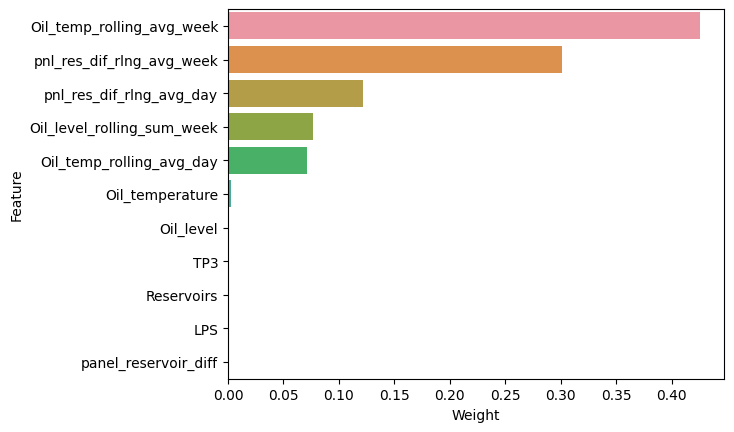

In [45]:
important_features = pd.DataFrame(data=zip(X2.columns, xgb_model2.feature_importances_), columns=["Feature","Weight"])



sns.barplot(data=important_features, x="Weight",y="Feature", order=important_features.sort_values("Weight", ascending=False).Feature)

Cross validation using XGBoost's cv, further verifying the feature importances.

In [46]:
dtrain = xgb.DMatrix(data=X2, label=y2)

params={"objective":"binary:hinge","max_depth":4}

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=5, num_boost_round=10, metrics="error", as_pandas=True)

print("Accuracy: %f" %((1-cv_results["test-error-mean"]).iloc[-1]))


Accuracy: 0.979743


In [47]:
cv_results

,train-error-mean,train-error-std,test-error-mean,test-error-std
0,0.786253,0.000162,0.786253,0.000649
1,0.143860,0.000115,0.143845,0.000417
2,0.086550,0.000186,0.086560,0.000230
3,0.043980,0.000173,0.043965,0.000181
4,0.039036,0.000164,0.039015,0.000190
5,0.041935,0.000096,0.041935,0.000296
6,0.031972,0.000114,0.031964,0.000294
7,0.032264,0.000107,0.032263,0.000256
8,0.025410,0.000057,0.025410,0.000144
9,0.020247,0.001886,0.020257,0.001854


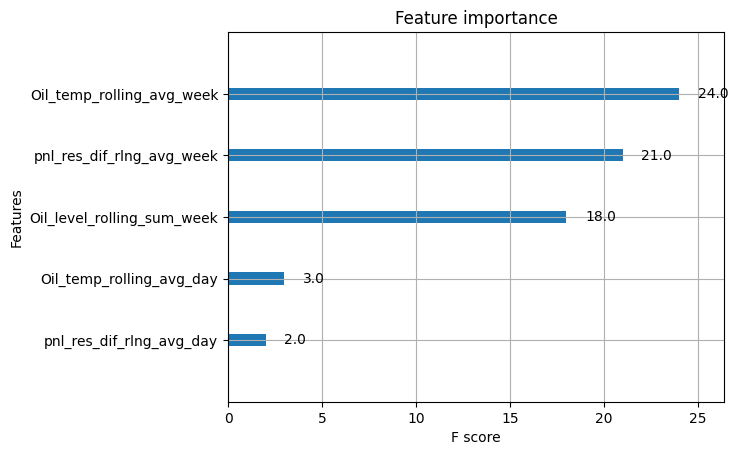

In [48]:
params ={'objective':'reg:logistic','seed':17, 'max_depth':3}

xgb_model3 = xgb.train(dtrain=dtrain, params=params, num_boost_round=10)

xgb.plot_importance(xgb_model3)
plt.show()

Relevant Papers:
[1]- Davari, N., Veloso, B., Ribeiro, R.P., Pereira, P.M., Gama, J.: Predictive maintenance based on anomaly
detection using deep learning for air production unit in the railway industry. In: 2021 IEEE 8th International
Conference on Data Science and Advanced Analytics (DSAA). pp. 1–10. IEEE (2021) (DOI:
10.1109/DSAA53316.2021.9564181) https://ieeexplore.ieee.org/document/9564181
 
[2] Veloso, B., Ribeiro, R.P., Pereira, P.M., Gama, J.: The MetroPT dataset for predictive maintenance. Scientific
Data 9, no. 1 (2022): 764. (DOI: 10.1038/s41597-022-01877-3)

[3]-Barros, M., Veloso, B., Pereira, P.M., Ribeiro, R.P., Gama, J.: Failure detection of an air production unit in the
operational context. In: IoT Streams for Data-Driven Predictive Maintenance and IoT, Edge, and Mobile for
Embedded Machine Learning, pp. 61–74. Springer (2020) (DOI: 10.1007/978-3-030-66770-2_5)

Source:
Narjes Davari, INESC TEC - Laboratory of Artificial Intelligence and Decision Support, narjes.davari@inesctec.pt
Bruno Veloso, INESC TEC - Laboratory of Artificial Intelligence and Decision Support, and Faculty of Economics,
University of Porto, Portugal bveloso@fep.up.pt
Rita P. Ribeiro, INESC TEC - Laboratory of Artificial Intelligence and Decision Support, and Faculty of Sciences,
University of Porto, Portugal. rpribeiro@fc.up.pt
Joao Gama, INESC TEC - Laboratory of Artificial Intelligence and Decision Support, and Faculty of Economics,
University of Porto, Portugal. jgama@fep.up.pt